In [1]:
from collections import defaultdict

import numpy as np

from mynn.layers.dense import dense
from mynn.optimizers.adam import Adam

from mygrad.nnet.losses import softmax_crossentropy
from mygrad.nnet.initializers import glorot_normal
from mygrad.nnet.activations import relu

import mygrad as mg

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import os
import librosa
from IPython.display import Audio

import pickle

import pandas as pd

In [2]:
class RNN():
    """Implements a simple-cell RNN that produces both outputs and hidden descriptors."""
    def __init__(self, dim_input, dim_recurrent, dim_output):
        """ Initializes all layers needed for RNN
        
        Parameters
        ----------
        dim_input: int 
            Dimensionality of data passed to RNN (C)
        
        dim_recurrent: int
            Dimensionality of hidden state in RNN (D)
        
        dim_output: int
            Dimensionality of output of RNN (K)
        """
        # Initialize one dense layer for each matrix multiplication that appears
        # in the simple-cell RNN equation; name these "layers" in ways that make
        # their correspondence to the equation obvious

        self.fc_x2h = dense(dim_input, dim_recurrent, weight_initializer=glorot_normal)
        self.fc_h2h = dense(dim_recurrent, dim_recurrent, weight_initializer=glorot_normal, bias=False)
        self.fc_h2y = dense(dim_recurrent, dim_output, weight_initializer=glorot_normal)

    
    
    def __call__(self, x, h=None):
        """ Performs the full forward pass for the RNN.
        
        Note that we will return the hidden states h_t and classification scores y_t for the
        full sequence, even though our loss will only utilize the last y_T.
        
        Parameters
        ----------
        x: Union[numpy.ndarray, mygrad.Tensor], shape=(T, C)
            The one-hot encodings for the sequence
        
        h: Optional[Union[numpy.ndarray, mygrad.Tensor]], shape=(1, D)
            An optional initial hidden dimension state h_0.
            If None, initialize an array of zeros.
        
        Returns
        -------
        Tuple[y, h]
            y: mygrad.Tensor, shape=(T, K)
                The final classification scores for each RNN step
            h: mygrad.Tensor, shape=(T, D)
                The hidden states computed at each RNN step, excluding the initial state h_0
        """
        # Initialize the hidden state h_{t=0} as zeros if an
        # initial hidden state is not provided as an argument.
        #
        # You will want to loop over each x_t to compute the
        # corresponding h_t, then store each h_t in a list.
        # You do not want to store the initial state h_{t=0}.
        #
        # You can use `mg.concatenate(list_of_h, axis=0)` to
        # create a shape-(T, K) tensor of hidden-descriptors.
        #
        # A standard for-loop is appropriate here. Be mindful of what the shape 
        # of x_t should be versus the shape of the item that it produced by the
        # for-loop.
        #
        # Note that you can do a for-loop over a mygrad-tensor and it will
        # produce sub-tensors that are tracked by the computational graph.
        # I.e. mygrad will be able to still "backprop" through your for-loop!
        
        # STUDENT CODE: 
        
        h_t = np.zeros((1, self.fc_h2h.weight.shape[0]), dtype=np.float32) if h is None else h # STUDENT CODE
        h = [] # we do not need to store the initial state, as we do not return it/use it to compute y
        
        for x_t in x:
            # `x_t[np.newaxis]` simply reshapes `x_t`: (C,) -> (1, C)
            #
            # h_t: shape-(1, D) hidden descriptor
            # STUDENT CODE:
            h_t = relu(self.fc_x2h(x_t[np.newaxis]) + self.fc_h2h(h_t))
            h.append(h_t)
        
        # shape-(T, D) collection of T descriptors (each shape-(D,))
        # STUDENT CODE:
        all_h = mg.concatenate(h, axis=0)
        
        # `all_y` is:
        # a shape-(T, K) collection of T "prediction scores", one produced
        # in association with each of the T hidden descriptors.
        #
        # We will only be making use of `all_y[-1:]` for our prediction
        # in our notebook; this is the shape-(1, K) vector associated with y_T
        # STUDENT CODE:
        all_y = self.fc_h2y(all_h)
        return all_y, all_h
    
    
    @property
    def parameters(self):
        """ A convenience function for getting all the parameters of our model.
        
        This can be accessed as an attribute, via `model.parameters` 
        
        Returns
        -------
        Tuple[Tensor, ...]
            A tuple containing all of the learnable parameters for our model
        """
        return self.fc_x2h.parameters + self.fc_h2h.parameters + self.fc_h2y.parameters
    
    def save_model(self, path):
        """Path to .npz file where model parameters will be saved"""
        with open(path, "wb") as f:
            np.savez(f, *(x.data for x in self.parameters))
            
    def load_model(self, path):
        with open(path, "rb") as f:
            for param, (name, array) in zip(self.parameters, np.load(f).items()):
                param.data[:] = array

In [3]:
def from_mp3(local_song_path: str, sr: int):
    """mp3 or other audio file to .npy"""
    samples, sample_rate = librosa.load(local_song_path, sr=sr, mono=True)

    return samples

In [4]:
instruments = ['Bass', 'Electric_Guitar', 'Glockenspiel', 'Organ', 'Piano', 'Pipa', 'Snare_Drum', 'String',
               'Vintage_lead', 'Violins', 'Alto Saxaphone', 'Cello', 'Clarinet', 'Flute', 'Guitar',
               'Horn', 'Oboe', 'Soprano Saxaphone', 'Trombone', 'Trumpet', 'Tuba', 'Viola',]

In [5]:
def train_model(model, optimizer, x, target, plotter):
    output, _ = model(x) 
    
    # We only want to use the final prediction scores.
    # `output[-1:]` returns y_T as shape-(1, D) tensor.
    #
    # `output[-1]` would return shape-(D,) tensor, which will
    # produce a shape issue
    # STUDENT CODE:

    output = output[-1:]
    
    loss = softmax_crossentropy(output, target)

    acc = float(np.argmax(output.data.squeeze()) == target.item())   

    plotter.set_train_batch({"loss":loss.item(), "accuracy":acc}, batch_size=1, plot=False)

    if k % plot_every == 0 and k > 0:
        plotter.set_train_epoch()

    loss.backward()
    optimizer.step()

In [102]:
def get_sequence(samples, sampling_rate):
    S, freqs, times = mlab.specgram(
    samples,
    NFFT=4096,
    Fs=sampling_rate,
    window=mlab.window_hanning,
    noverlap=int(4096 / 2),
    mode='magnitude'
)

    step = 1 # only every step-th frequency recorded, for efficiency
    bins = 90 # example, frequency in 30 bins --> every 300 (0, 300, 600, ... 9000)
    freq_interval = 9000/bins
    
    sequence = np.array([freqs[np.argmax(S[j])] for j in range(0,len(S[0]), step)])
    sequence = sequence/freq_interval 
    sequence = sequence.astype(int)
    sequence[sequence > 9000] = 9000

    x = np.zeros((len(sequence), bins), dtype=np.float32)

    for i, ch in enumerate(sequence):
        x[i, int(ch)] = 1

    return x

In [76]:
def compile_set(half, include):
    """0 for first half, 1 for second half
    include is a list of insturments to include"""
    sequences = []
    target_list = []
    
    ### First data set
    set1 = os.listdir("./instruments")
    
    if half == 0:
        start = 0
        stop = int(len(set1)*3/4)
    else:
        start = int(len(set1)*3/4)
        stop = len(set1)
    
    for k in range(start, stop):
        instrument = set1[k][2:][:-4].strip() ## name of instrument   
        
        if instrument in include:
    
            sampling_rate = 44100
            samples = from_mp3("./instruments/"+set1[k],sampling_rate)

            x = get_sequence(samples, sampling_rate)
            
            if instrument in brass:
                ind = 0
            elif instrument in woodwind:
                ind = 1
            elif instrument in strings:
                ind = 2
            elif instrument in keys:
                ind = 3
            elif instrument in precussion:
                ind = 4
            else:
                ind = 5 # other

            #targets_bool = include.index(instrument) == np.arange(len(include))
            targets_bool = ind == np.arange(6)
            targets = targets_bool.astype(int)

            sequences.append(x)
            target_list.append(targets)
    
    ### Second data set
    folders = os.listdir("./instruments_set2/MusicDataBaseonly_WAV_files")

    for folder in folders:
        if folder in include:
            print(folder)
            files = os.listdir("./instruments_set2/MusicDataBaseonly_WAV_files/" + folder)

            if half == 0:
                start = 0
                stop = int(len(files)*3/4)
            else:
                start = int(len(files)*3/4)
                stop = len(files)

            for j in range(start, stop):
                sampling_rate = 44100
                samples = from_mp3("./instruments_set2/MusicDataBaseonly_WAV_files/" + folder + "/" + files[j], sampling_rate)

                x = get_sequence(samples, sampling_rate)

                if folder in brass:
                    ind = 0
                elif folder in woodwind:
                    ind = 1
                elif folder in strings:
                    ind = 2
                elif folder in keys:
                    ind = 3
                elif folder in precussion:
                    ind = 4
                else:
                    ind = 5 # other
                    
                targets_bool = ind == np.arange(6)
                targets = targets_bool.astype(int)

                sequences.append(x)
                target_list.append(targets)
            
    return target_list, sequences

In [8]:
brass = ['Horn','Trombone', 'Trumpet', 'Tuba']
woodwind = ['Alto Saxaphone', 'Clarinet', 'Flute','Oboe', 'Soprano Saxaphone']
strings = ['Bass', 'Electric_Guitar', 'Pipa', 'String','Violins', 'Cello', 'Guitar', 'Viola']
keys = ['Organ', 'Piano']
precussion = ['Glockenspiel', 'Snare_Drum']

In [103]:
train_targets, train_sequences = compile_set(0, instruments)
test_targets, test_sequences = compile_set(1, instruments)

Alto Saxaphone
Bass
Cello
Clarinet
Flute
Guitar
Horn
Oboe
Soprano Saxaphone
Trombone
Trumpet
Tuba
Viola
Violins
Alto Saxaphone
Bass
Cello
Clarinet
Flute
Guitar
Horn
Oboe
Soprano Saxaphone
Trombone
Trumpet
Tuba
Viola
Violins


In [110]:
with open("./singles_data/singles_train_targets.bin", "wb") as f:
    pickle.dump(train_targets, f)
    f.close()
with open("./singles_data/singles_train_dat.bin", "wb") as f:
    pickle.dump(train_sequences, f)
    f.close()
with open("./singles_data/singles_test_targets.bin", "wb") as f:
    pickle.dump(test_targets, f)
    f.close()
with open("./singles_data/singles_test_dat.bin", "wb") as f:
    pickle.dump(test_sequences, f)
    f.close()

In [38]:
with open("./singles_data/singles_train_dat.bin", "rb") as f:
    train_sequences = pickle.load(f)
    f.close()
with open("./singles_data/singles_train_targets.bin", "rb") as f:
    train_targets = pickle.load(f)
    f.close()

In [70]:
mg.turn_memory_guarding_off()
plot_every = 20

In [104]:
inds_arr = np.arange(len(train_targets))
np.random.shuffle(inds_arr)
print(inds_arr)

[ 750  522 1946 ... 2016  696 2090]


## Model

<IPython.core.display.Javascript object>


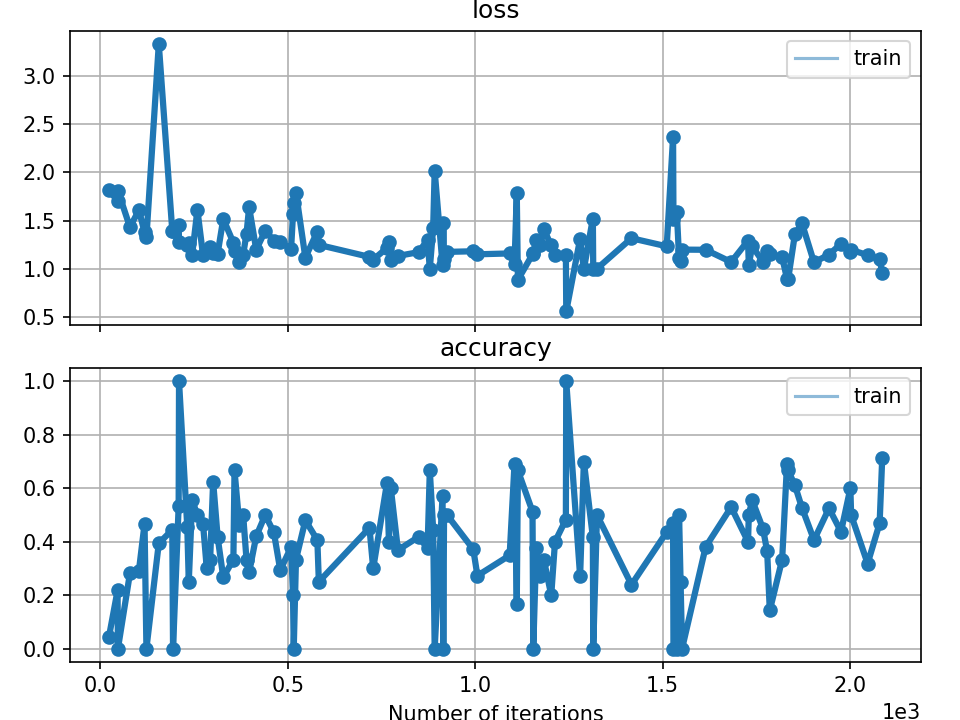

In [105]:
from noggin import create_plot
plotter, fig, ax = create_plot(["loss", "accuracy"])

In [108]:
model = RNN(dim_input=90, dim_recurrent=50, dim_output=6)
optimizer = Adam(model.parameters)

In [109]:
for k in inds_arr:
    targets = np.where(train_targets[k]==1)[0]
    x = train_sequences[k]
    
    train_model(model, optimizer, x, targets, plotter)

In [111]:
model.save_model("./model/model.npy")

## Test

In [36]:
model.load_model("./model/model.npy")

In [112]:
def test_model(dat):
    output = []
    for d in dat:
        out, _ = model(d)
        output.append(np.argmax(out[-1:].data.squeeze()))
    return output

In [113]:
with open("./singles_data/singles_test_dat.bin", "rb") as f:
    test_sequences = pickle.load(f)
    f.close()

In [114]:
with open("./singles_data/singles_test_targets.bin", "rb") as f:
    test_targets = pickle.load(f)
    f.close()

In [115]:
out = test_model(test_sequences)

In [116]:
targets = []
for t in test_targets:
    targets.append(np.where(t==1)[0][0])

In [117]:
print(out[0:24])
print(targets[0:24])

[2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1]
[2, 4, 2, 5, 2, 2, 2, 4, 3, 3, 2, 4, 2, 5, 2, 2, 2, 4, 3, 3, 2, 4, 2, 5]


In [131]:
accuracy = [out[i] == targets[i] for i in range(0,len(out))]

In [134]:
sum(accuracy)/len(out)

0.4314002828854314

## Song

In [146]:
def test_song(local_song_path: str, sr: int, len_song):
    out_arr = []
    times = [] # start times
    for i in range(0, len_song, 4):
        samples, sample_rate = librosa.load(local_song_path, sr=sr, mono=True, offset=i, duration=4)
        
        x = get_sequence(samples, sample_rate)
        
        out, _ = model(x)
        out_arr.append(np.argmax(out[-1:].data.squeeze()))
        
        times.append(i)
    
    return out_arr, times

In [147]:
sampling_rate = 44100
instrument_arr, ts = test_song("./MusicMP3s/"+"David Bowie - Space Oddity"+".mp3",sampling_rate, 305)

In [148]:
print(instrument_arr)

[1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1]
